In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
plt.style.use('seaborn')

##### [과제] bike_train.csv를 불어와서 다음 사항들을 고려하여 자전거 대여횟수를 예측하는 모델을 생성 후 평가하세요.
---

- datetime 타입에서 년, 월, 일, 시간 추출하여 반영 후 선형회귀 모델링 및 평가 
    - 평가 사용자 함수 : RMSLE, RMSE, MAE
- 종속변수 정규성 개선위한 로그 변환
    - 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
    - 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할 
    - 선형회귀, ridge, lasso model 별로 평가 수행
    - 회귀계수 중요도 시각화

In [2]:
bike_df = pd.read_csv('../data/bike_train.csv')
bike_test = pd.read_csv('../data/bike_test.csv')

bike_df.info()
bike_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_df['datetime'] = pd.to_datetime(bike_df.datetime)
bike_test['datetime'] = pd.to_datetime(bike_test.datetime)

bike_df['year'] = bike_df['datetime'].dt.year
bike_df['month'] = bike_df['datetime'].dt.month
bike_df['day'] = bike_df['datetime'].dt.day
bike_df['hour'] = bike_df['datetime'].dt.hour
bike_df['hour'] = bike_df['datetime'].dt.hour

bike_test['year'] = bike_df['datetime'].dt.year
bike_test['month'] = bike_df['datetime'].dt.month
bike_test['day'] = bike_df['datetime'].dt.day
bike_test['hour'] = bike_df['datetime'].dt.hour
bike_test['hour'] = bike_df['datetime'].dt.hour

bike_df1 = bike_df.drop('datetime', axis = 1)
display(bike_df1.head())

bike_test1 = bike_test.drop('datetime', axis = 1)
display(bike_test1.head())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,1,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,1,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,1,4


In [4]:
X = bike_df1.drop(['count', 'casual', 'registered'], axis = 1)
# y = np.log1p(bike_df1['count'])
y = bike_df1['count']

lr_reg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
# pred = np.expm1(pred)
# y_test

def get_eval(y_test, pred):
    rmse = mean_squared_error(y_test, pred, squared = False)
#     msle = mean_squared_log_error(y_test, pred, squared = False)
    mae = mean_absolute_error(y_test, pred)
    rmsle = np.sqrt(np.mean(np.square(np.log1p(y_test) - np.log1p(pred))))
    print('rmse :', round(rmse, 3))
    print('mae :', round(mae, 3))    
    print('rmsle :', round(rmsle, 3))


get_eval(y_test, pred)

rmse : 140.9
mae : 105.924
rmsle : 1.165


C:\Users\spiner\AppData\Local\Temp/ipykernel_1568/1003797188.py:16: RuntimeWarning: invalid value encountered in log1p
  rmsle = np.sqrt(np.mean(np.square(np.log1p(y_test) - np.log1p(pred))))


In [97]:
X_re = X.copy()
y_re = np.log1p(y)

for i in ['year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather']:
    X_re[i] = X[i].astype(str)

# X_re = pd.get_dummies(X_re, columns = ['year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather'])
X_re = pd.get_dummies(X_re)
print(X_re.columns)
X_re['month_10'][X_re['month_10'] == 1].index

Index(['temp', 'atemp', 'humidity', 'windspeed', 'season_1', 'season_2',
       'season_3', 'season_4', 'holiday_0', 'holiday_1', 'workingday_0',
       'workingday_1', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'year_2011', 'year_2012', 'month_1', 'month_10', 'month_11', 'month_12',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'day_1', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'hour_0',
       'hour_1', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_2',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9'],
      dtype='object')


Int64Index([4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064,
            ...
            9965, 9966, 9967, 9968, 9969, 9970, 9971, 9972, 9973, 9974],
           dtype='int64', length=911)

In [96]:
X_re1 = X.copy()

X_re1 = pd.get_dummies(X_re1, columns = ['year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather'])
print(X_re1.columns)
X_re1['month_10'][X_re1['month_10'] == 1].index

Index(['temp', 'atemp', 'humidity', 'windspeed', 'year_2011', 'year_2012',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8',
       'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15',
       'day_16', 'day_17', 'day_18', 'day_19', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'season_1', 'season_2', 'season_3', 'season_4',
       'holiday_0', 'holiday_1', 'workingday_0', 'workingday_1', 'weather_1',
       'weather_2', 'weather_3', 'weather_4'],
      dtype='object')


Int64Index([4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064,
            ...
            9965, 9966, 9967, 9968, 9969, 9970, 9971, 9972, 9973, 9974],
           dtype='int64', length=911)

*** Ridge(alpha=10, random_state=0) ***
rmse : 98.529
mae : 63.893
rmsle : 0.59

*** Lasso(alpha=0.005, random_state=0) ***
rmse : 104.066
mae : 66.671
rmsle : 0.602

*** LinearRegression(n_jobs=-1) ***
rmse : 97.688
mae : 63.382
rmsle : 0.59



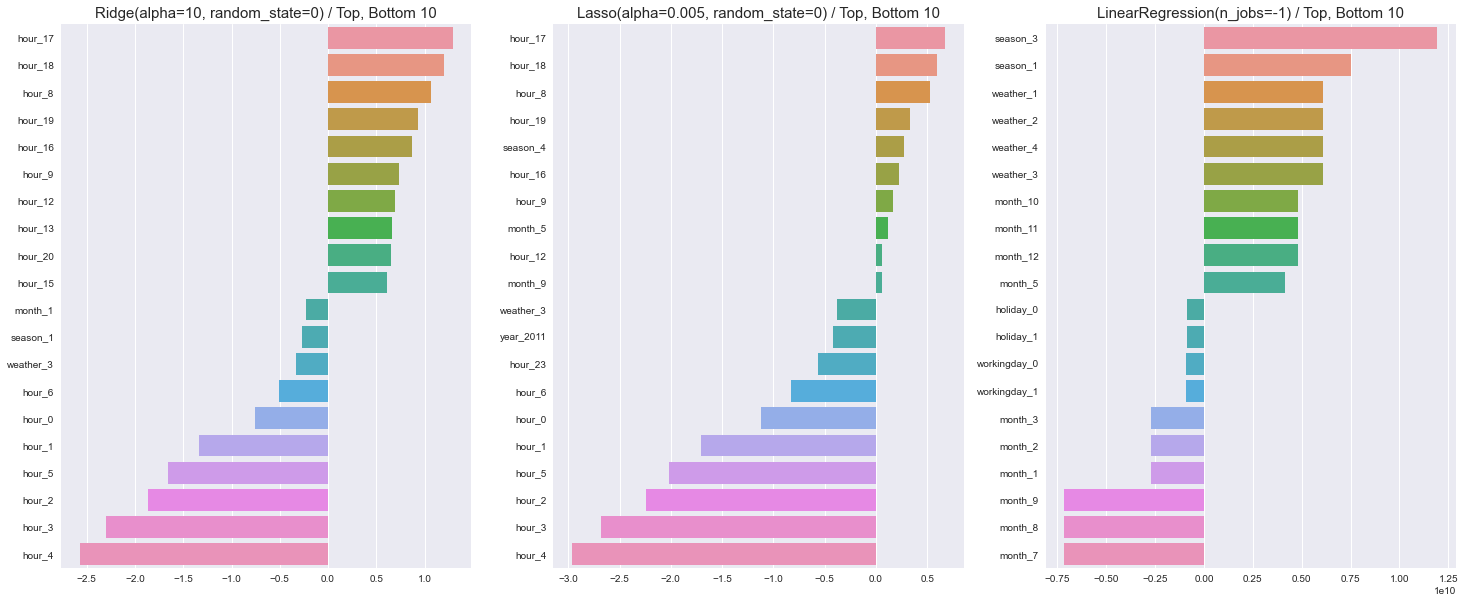

In [58]:
ridge = Ridge(alpha = 10, random_state = 0)
lasso = Lasso(alpha = 0.005, random_state = 0)
lr_reg = LinearRegression(n_jobs = -1)

X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size = 0.3, random_state = 0)

for i in [ridge, lasso, lr_reg]:
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    pred_re = np.expm1(pred)
    y_test_re = np.expm1(y_test)
    print('***', i, '***')
    get_eval(y_test_re, pred_re)
    print()
    
fig = plt.figure(figsize = (25, 10))   
for i, j in enumerate([ridge, lasso, lr_reg]):
    j.fit(X_train, y_train)
    coef = pd.Series(j.coef_, index = X_re.columns).sort_values(ascending = False)
    coef_re = pd.concat([coef[:10], coef[-10:]])
    fig.add_subplot(1, 3, i+1)
    sns.barplot(x = coef_re, y = coef_re.index)
    plt.title(f'{j} / Top, Bottom 10', fontsize = 15)
plt.show()

*** Ridge(alpha=10, random_state=0) ***
rmse : 98.529
mae : 63.893
rmsle : 0.59

*** Lasso(alpha=0.005, random_state=0) ***
rmse : 104.068
mae : 66.672
rmsle : 0.602

*** LinearRegression(n_jobs=-1) ***
rmse : 97.69
mae : 63.383
rmsle : 0.59



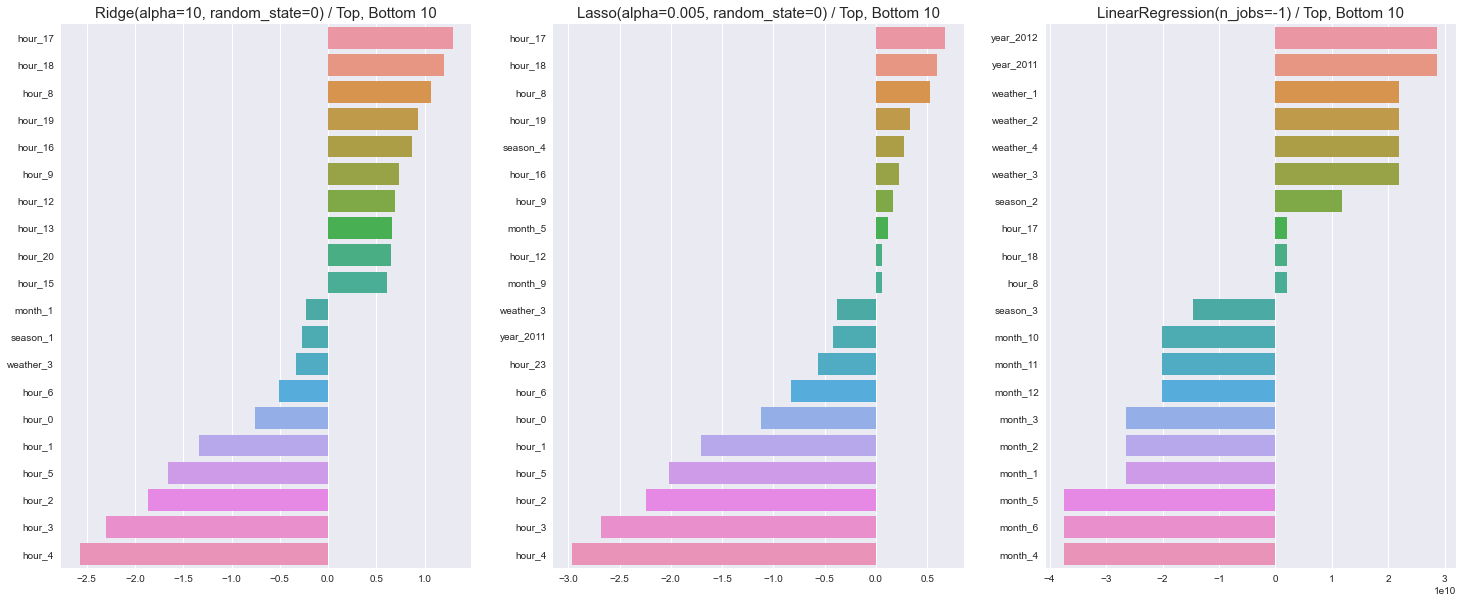

In [95]:
ridge = Ridge(alpha = 10, random_state = 0)
lasso = Lasso(alpha = 0.005, random_state = 0)
lr_reg = LinearRegression(n_jobs = -1)

X_train, X_test, y_train, y_test = train_test_split(X_re1, y_re, test_size = 0.3, random_state = 0)

for i in [ridge, lasso, lr_reg]:
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    pred_re = np.expm1(pred)
    y_test_re = np.expm1(y_test)
    print('***', i, '***')
    get_eval(y_test_re, pred_re)
    print()
    
fig = plt.figure(figsize = (25, 10))   
for i, j in enumerate([ridge, lasso, lr_reg]):
    j.fit(X_train, y_train)
    coef = pd.Series(j.coef_, index = X_re1.columns).sort_values(ascending = False)
    coef_re = pd.concat([coef[:10], coef[-10:]])
    fig.add_subplot(1, 3, i+1)
    sns.barplot(x = coef_re, y = coef_re.index)
    plt.title(f'{j} / Top, Bottom 10', fontsize = 15)
plt.show()

In [406]:
coef = pd.Series(lr_reg.coef_, X_re.columns).sort_values(ascending = False)
pd.concat([coef[:10], coef[-10:]])

season_3        9.821539e+09
month_10        5.171756e+09
month_11        5.171756e+09
month_12        5.171756e+09
weather_1       1.977515e+09
weather_2       1.977515e+09
weather_4       1.977515e+09
weather_3       1.977515e+09
hour_17         1.968356e+09
hour_18         1.968356e+09
day_7          -1.820156e+08
year_2012      -1.243782e+09
year_2011      -1.243782e+09
season_2       -1.511286e+09
workingday_0   -3.342079e+09
workingday_1   -3.342079e+09
season_4       -4.997085e+09
month_9        -9.646868e+09
month_8        -9.646868e+09
month_7        -9.646868e+09
dtype: float64

##### [도전과제] 캐글 주택가격 예측 및 평가를 아래 사이트를 참조하여 수행하세요.
---

https://www.kaggle.com/c/house-prices-advanced-regression-techniques
